Using device: cpu
Epoch 1, Loss: 0.000612
Epoch 2, Loss: 0.000077


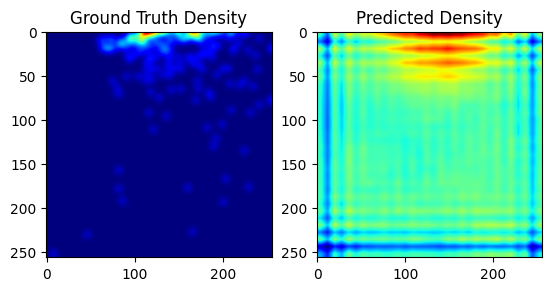

In [3]:

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.ndimage


class CSRNetEfficient(nn.Module):
    def __init__(self):
        super(CSRNetEfficient, self).__init__()
        vgg = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1)

        # Frontend: VGG16 layers up to conv5_3
        self.frontend = nn.Sequential(*list(vgg.features.children())[:33])

        # Backend: compact & dilated convolutions
        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, 1)  # density map output
        )

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        return x


def generate_density_map(points, image_shape, sigma=4):
    """
    points: N x 2 array of head coordinates (x, y)
    image_shape: (height, width)
    sigma: Gaussian blur size
    """
    h, w = image_shape
    density = np.zeros((h, w), dtype=np.float32)
    for point in points:
        x = min(w-1, max(0, int(point[0])))
        y = min(h-1, max(0, int(point[1])))
        density[y, x] = 1
    density = scipy.ndimage.gaussian_filter(density, sigma=sigma)
    return density



class CrowdDataset(Dataset):
    def __init__(self, img_dir, gt_dir, transform=None):
        self.img_dir = img_dir
        self.gt_dir = gt_dir
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith(".jpg")]
        self.transform = transform if transform else transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        img = Image.open(img_path).convert("RGB")
        
        
        orig_w, orig_h = img.size

       
        if self.transform:
            img_transformed = self.transform(img)
        else:
            img_transformed = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.ToTensor()
            ])(img)

       
        gt_name = "GT_" + os.path.splitext(self.img_files[idx])[0] + ".mat"
        gt_path = os.path.join(self.gt_dir, gt_name)
        mat = sio.loadmat(gt_path)

        if "image_info" in mat:
            annPoints = mat["image_info"][0,0][0,0][0]

           
            scale_x = 256 / orig_w
            scale_y = 256 / orig_h
            points = np.array([[p[0]*scale_x, p[1]*scale_y] for p in annPoints])
            density = generate_density_map(points, (256, 256), sigma=4)
        else:
            density = mat["density"].astype(np.float32)

        density = torch.from_numpy(density).unsqueeze(0)  # [1,H,W]
        return img_transformed, density



def train_eval():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Using device:", device)

    # Dataset paths
    root = r"D:\Task For Infosys Internship\archive\ShanghaiTech\part_B"
    train_img_dir = os.path.join(root, "train_data", "images")
    train_gt_dir = os.path.join(root, "train_data", "ground-truth")

    dataset = CrowdDataset(train_img_dir, train_gt_dir)
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

    model = CSRNetEfficient().to(device)
    loss_fn = nn.MSELoss()
    opt = optim.Adam(model.parameters(), lr=1e-5)

    
    for epoch in range(2):
        model.train()
        epoch_loss = 0.0
        for imgs, dens in dataloader:
            imgs, dens = imgs.to(device), dens.to(device)

            out = model(imgs)

            # Fix size mismatch with interpolation
            if out.shape != dens.shape:
                out = nn.functional.interpolate(out, size=dens.shape[2:], mode="bilinear", align_corners=False)

            loss = loss_fn(out, dens)
            opt.zero_grad()
            loss.backward()
            opt.step()
            epoch_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(dataloader):.6f}")


    model.eval()
    test_img, test_dens = dataset[0]
    with torch.no_grad():
        pred = model(test_img.unsqueeze(0).to(device))
        pred = nn.functional.interpolate(pred, size=test_dens.shape[1:], mode="bilinear", align_corners=False)
        pred = pred.squeeze().cpu().numpy()

    plt.subplot(1, 2, 1)
    plt.title("Ground Truth Density")
    plt.imshow(test_dens.squeeze(), cmap="jet")

    plt.subplot(1, 2, 2)
    plt.title("Predicted Density")
    plt.imshow(pred, cmap="jet")
    plt.show()

if __name__ == "__main__":
    train_eval()


Using device: cpu
Epoch 1, Loss: 0.003350
Epoch 2, Loss: 0.000314


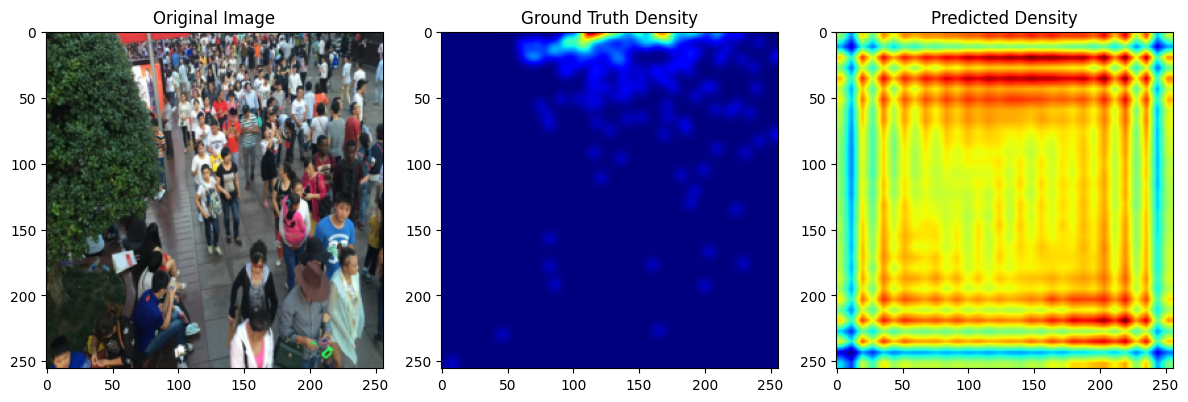

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.ndimage

class CSRNetEfficient(nn.Module):
    def __init__(self):
        super(CSRNetEfficient, self).__init__()
        vgg = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1)
        self.frontend = nn.Sequential(*list(vgg.features.children())[:33])
        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, 1)
        )

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        return x

def generate_density_map(points, image_shape, sigma=4):
    h, w = image_shape
    density = np.zeros((h, w), dtype=np.float32)
    for point in points:
        x = min(w-1, max(0, int(point[0])))
        y = min(h-1, max(0, int(point[1])))
        density[y, x] = 1
    density = scipy.ndimage.gaussian_filter(density, sigma=sigma)
    return density

class CrowdDataset(Dataset):
    def __init__(self, img_dir, gt_dir, transform=None):
        self.img_dir = img_dir
        self.gt_dir = gt_dir
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith(".jpg")]
        self.transform = transform if transform else transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        img = Image.open(img_path).convert("RGB")
        orig_w, orig_h = img.size
        if self.transform:
            img_transformed = self.transform(img)
        else:
            img_transformed = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.ToTensor()
            ])(img)
        gt_name = "GT_" + os.path.splitext(self.img_files[idx])[0] + ".mat"
        gt_path = os.path.join(self.gt_dir, gt_name)
        mat = sio.loadmat(gt_path)
        if "image_info" in mat:
            annPoints = mat["image_info"][0,0][0,0][0]
            scale_x = 256 / orig_w
            scale_y = 256 / orig_h
            points = np.array([[p[0]*scale_x, p[1]*scale_y] for p in annPoints])
            density = generate_density_map(points, (256, 256), sigma=4)
        else:
            density = mat["density"].astype(np.float32)
        density = torch.from_numpy(density).unsqueeze(0)
        return img_transformed, density

def train_eval():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Using device:", device)
    root = r"D:\Task For Infosys Internship\archive\ShanghaiTech\part_B"
    train_img_dir = os.path.join(root, "train_data", "images")
    train_gt_dir = os.path.join(root, "train_data", "ground-truth")
    dataset = CrowdDataset(train_img_dir, train_gt_dir)
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
    model = CSRNetEfficient().to(device)
    loss_fn = nn.MSELoss()
    opt = optim.Adam(model.parameters(), lr=1e-5)
    for epoch in range(2):
        model.train()
        epoch_loss = 0.0
        for imgs, dens in dataloader:
            imgs, dens = imgs.to(device), dens.to(device)
            out = model(imgs)
            if out.shape != dens.shape:
                out = nn.functional.interpolate(out, size=dens.shape[2:], mode="bilinear", align_corners=False)
            loss = loss_fn(out, dens)
            opt.zero_grad()
            loss.backward()
            opt.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(dataloader):.6f}")
    model.eval()
    test_img, test_dens = dataset[0]
    with torch.no_grad():
        pred = model(test_img.unsqueeze(0).to(device))
        pred = nn.functional.interpolate(pred, size=test_dens.shape[1:], mode="bilinear", align_corners=False)
        pred = pred.squeeze().cpu().numpy()
    img_np = test_img.permute(1, 2, 0).cpu().numpy()
    img_np = np.clip(img_np, 0, 1)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(img_np)
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Density")
    plt.imshow(test_dens.squeeze(), cmap="jet")
    plt.subplot(1, 3, 3)
    plt.title("Predicted Density")
    plt.imshow(pred, cmap="jet")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    train_eval()
